In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

from PhaseFunctionedNetwork import PhaseFunctionedNetwork
from train_utils import train_pfnn_thresh

# set seeds for reproduceability
torch.manual_seed(42)
np.random.seed(42)
rng = np.random.RandomState(42)

# TODO THIS IS THE MAIN TRAINING NOTEBOOK CLEAUP AND MAKE BETTER
# Style 1 - Idle
# Style 2 - Jump
    # 0 - flat
    # 1 - up 
    # 2 - down

# Expriments with all data varieties

In [2]:
ROUND = 2
INPUT_PATH = 'Input_'
OUTPUT_PATH = 'Output_'

def get_change_in_phase(phase_arr):
    change_in_phase =  phase_arr[1:] - phase_arr[:-1]
    change_in_phase[change_in_phase < 0] = (1.0 - phase_arr[:-1] + phase_arr[1:])[change_in_phase < 0]
    change_in_phase = np.append(change_in_phase, change_in_phase[-1]) #TODO IF BREAKS append 2pi
    return change_in_phase

def get_phase_acyclic(X_arr):
    # P_arr = np.round(np.linspace(0, 0.99, num=X_arr.shape[0]), ROUND)
    P_arr = np.linspace(0, 0.99, num=X_arr.shape[0])

    return P_arr

def get_phase_cyclic(X_arr, num_repetitions):
    total_len = X_arr.shape[0]
    
    cycle_len = total_len // num_repetitions
    cycle = np.linspace(0, 0.99, num=cycle_len, endpoint=False)
    # Repeat
    P_arr = np.tile(cycle, num_repetitions)

    # If not long enough add from beggining of cycle
    P_arr_len = len(P_arr)
    if P_arr_len < total_len:
        pad_to = total_len - P_arr_len
        P_arr = np.concatenate([P_arr, cycle[:pad_to]])

    # P_arr = np.round(P_arr, ROUND)
    return P_arr

In [3]:
INPUT_PREFIX = 'Input_'
OUTPUT_PREFIX = 'Output_'

EXTENSION = '.txt'

def load_data(data_dir, action_num):
    X_arr = np.float32(np.loadtxt(data_dir + INPUT_PREFIX + action_num + EXTENSION))
    Y_arr = np.float32(np.loadtxt(data_dir + OUTPUT_PREFIX + action_num + EXTENSION))
    
    return X_arr, Y_arr

def process_data(X_arr, Y_arr, P_arr, delta_phase_arr, num_files, data_dir, split_stats_arr, cyclic_action=True):
    prev_data = sum(arr.shape[0] for arr in X_arr) + sum(arr.shape[0] for arr in Y_arr) 
    for i in range(int(num_files/2)):
        input_data, output_data = load_data(data_dir, str(i))

        if(cyclic_action):
            phase_data = get_phase_cyclic(input_data, 3)
        else:
            phase_data = get_phase_acyclic(input_data)

        change_in_phase = get_change_in_phase(phase_data)

        X_arr.append(input_data)
        Y_arr.append(output_data)
        P_arr = np.append(P_arr, phase_data)
        delta_phase_arr = np.append(delta_phase_arr, change_in_phase)

    current_data = sum(arr.shape[0] for arr in X_arr) + sum(arr.shape[0] for arr in Y_arr)
    split_stats_arr.append(current_data - prev_data)

    return X_arr, Y_arr, P_arr, delta_phase_arr, split_stats_arr

In [4]:
# WEIGH THE JOINT (in particular all the hand and foot joints need to be weighted less)
JOINT_NUM = 144

joint_weights = np.array([
    1,                                                  # HIPS
    1, 1, 1,                                            # LEFT leg
    1e-10, 1e-10, 1e-10, 1,                             # LEFT foot thumb
    1,                                                  # LEFT foot toe base
    1e-10, 1e-10, 1e-10, 1,                             # LEFT foot index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT foot middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT foot ring
    1, 1, 1,                                            # RIGHT leg
    1e-10, 1e-10, 1e-10, 1,                             # RIGHT foot thumb
    1,                                                  # RIGHT foot toe base
    1e-10, 1e-10, 1e-10, 1,                             # RIGHT foot index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT foot middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT foot ring
    1, 1, 1, 1,                                         # SPINE
    1, 1,                                               # LEFT shoulder
    1, 1,                                               # LEFT arm
    1,                                                  # LEFT hand
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT hand index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT hand middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # LEFT hand ring
    1, 1e-10, 1,                                        # LEFT wing feathers large
    1, 1e-10, 1,                                        # LEFT wing feathers medium
    1,                                                  # LEFT wing feathers small
    1, 1, 1, 1, 1, 1, 1,                                # NECK
    1,                                                  # HEAD
    1e-10, 1e-10,                                       # JAW
    1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10,    # TONUGE
    1e-10, 1e-10, 1e-10,                                # LEFT eye
    1e-10, 1e-10, 1e-10,                                # RIGHT eye
    1, 1,                                               # RIGHT shoulder
    1, 1,                                               # RIGHT arm
    1,                                                  # RIGHT hand
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT hand index
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT hand middle
    1e-10, 1e-10, 1e-10, 1e-10, 1,                      # RIGHT hand ring
    1, 1e-10, 1,                                        # RIGHT wing feathers large
    1, 1e-10, 1,                                        # RIGHT wing feathers medium
    1,                                                  # RIGHT wing feathers small
    1, 1, 1, 1, 1, 1, 1, 1, 1,                          # TAIL
    1e-10, 1e-10, 1,                                    # LEFT tail feather
    1e-10, 1e-10, 1,                                    # MIDDLE tail feather         
    1e-10, 1e-10, 1                                     # RIGHT tail feather 
])

# repeat weights for each joint to represent X, Y and Z
joint_weights = joint_weights.repeat(3)

In [31]:
# Automatic processing of idle and jumps
ROOT_DIR = 'C:/Users/Ana/Desktop/dev/pfnn-dev/Export/chapter3_experiments/trajectory/v2/'
IDLE_DATA_DIR = ROOT_DIR + 'idle/'
JUMP_DATA_DIR = ROOT_DIR + 'jump/'

split_stats = []
X = []
Y = []
P = np.empty(0)
delta_phase = np.empty(0)

# Process idle data
file_count = sum(1 for filename in os.listdir(IDLE_DATA_DIR) if filename.endswith('.txt'))
X, Y, P, delta_phase, split_stats = process_data(X, Y, P, delta_phase, file_count, data_dir=IDLE_DATA_DIR, split_stats_arr=split_stats, cyclic_action=True)

# Process jump data
file_count = sum(1 for filename in os.listdir(JUMP_DATA_DIR) if filename.endswith('.txt'))
X, Y, P, delta_phase, split_stats = process_data(X, Y, P, delta_phase, file_count, data_dir=JUMP_DATA_DIR, split_stats_arr=split_stats, cyclic_action=False)

In [32]:
# stack all the arrays on top of each other
X = np.vstack(X)
Y = np.vstack(Y)
delta_phase = delta_phase.flatten()
P = P.flatten()
Y = np.concatenate([Y, delta_phase [..., np.newaxis]], axis=-1)

# print stats 
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"Phase data shape: {P.shape}")
print(f"Delta phase shape: {delta_phase.shape}")

# Action 0 --> Idle
# Action 1 --> Jump
# print data distribution stats (walk/idle) 
total_data = sum(data for data in split_stats)
for i in range(len(split_stats)):
    print(f"Action {i} = {np.round(split_stats[i]/total_data * 100, 2)}%")

Input data shape: (226, 960)
Output data shape: (226, 892)
Phase data shape: (226,)
Delta phase shape: (226,)
Action 0 = 31.86%
Action 1 = 68.14%


In [33]:
def preprocess_X_2Styles(X_arr):
    Xmean, Xstd = X_arr.mean(axis=0), X_arr.std(axis=0)

    # lists to keep track of indices for TRAJECTORY
    X_traj_pos_indices = []
    X_traj_dir_indices = []
    X_traj_style_indices = []
    X_traj_slope_indices = []

    # number of eleements for each trajectory point
    w = 8
    for i in range(0, 95, w):
        X_traj_pos_indices = np.append(X_traj_pos_indices, range(i,i+3)).astype(int)
        X_traj_dir_indices = np.append(X_traj_dir_indices, range(i+3,i+5)).astype(int)
        X_traj_slope_indices = np.append(X_traj_slope_indices, i+5).astype(int)
        X_traj_style_indices = np.append(X_traj_style_indices, range(i+6,i+8)).astype(int)

    # lists to keep track of indices for JOINTS
    X_joint_pos_indices = []
    X_joint_vel_indices = []

    # num of elements for each joint
    w = 6
    for i in range(96, 959, w):
        X_joint_pos_indices = np.append(X_joint_pos_indices, range(i,i+3)).astype(int)
        X_joint_vel_indices = np.append(X_joint_vel_indices, range(i+3,i+6)).astype(int)

    # INPUT Trajectory data
    Xstd[X_traj_pos_indices] = Xstd[X_traj_pos_indices].mean()
    Xstd[X_traj_dir_indices] = Xstd[X_traj_dir_indices].mean()
    Xstd[X_traj_style_indices] = Xstd[X_traj_style_indices].mean()
    Xstd[X_traj_slope_indices] = Xstd[X_traj_slope_indices].mean()

    # INPUT Joint data --> This is where we weight the joints
    Xstd[X_joint_pos_indices] = Xstd[X_joint_pos_indices].mean() / (joint_weights * 0.1)
    # Xstd[X_joint_vel_indices] = Xstd[X_joint_vel_indices].mean() / (joint_weights * 0.1)
    # Xstd[X_joint_pos_indices] = Xstd[X_joint_pos_indices].mean() 
    # Xstd[X_joint_vel_indices] = Xstd[X_joint_vel_indices].mean()

    return Xmean, Xstd

def preprocess_Y(Y_arr):
    Ymean, Ystd = Y_arr.mean(axis=0), Y_arr.std(axis=0)

    # PREPROCESS OUTPUT Y
    # lists to keep track of indices for TRAJECTORY
    Y_traj_pos_indices = []
    Y_traj_dir_indices = []

    # number of trajectory elements
    w = 4
    for i in range(0, 23, w): #TODO UPDATE THE RANGE
        Y_traj_pos_indices = np.append(Y_traj_pos_indices, range(i,i+2)).astype(int)
        Y_traj_dir_indices = np.append(Y_traj_dir_indices, range(i+2,i+4)).astype(int)

    # lists to keep track of indices for JOINTS
    Y_joint_pos_indices = []
    Y_joint_vel_indices = []

    # num of joint elements
    w = 6
    for i in range(24, 887, w): #TODO UPDATE THE RANGE
        Y_joint_pos_indices = np.append(Y_joint_pos_indices, range(i,i+3)).astype(int)
        Y_joint_vel_indices = np.append(Y_joint_vel_indices, range(i+3,i+6)).astype(int)

    # OUTPUT Trajectory data
    Ystd[Y_traj_pos_indices] = Ystd[Y_traj_pos_indices].mean()
    Ystd[Y_traj_dir_indices] = Ystd[Y_traj_dir_indices].mean()

    # OUTPUT Joint data --> This is where we weight the joints
    Ystd[Y_joint_pos_indices] = Ystd[Y_joint_pos_indices].mean()
    Ystd[Y_joint_vel_indices] = Ystd[Y_joint_vel_indices].mean()
    
    # translational_vel_mean = (Ystd[-4] + Ystd[-2])/2
    # Ystd[-4] = translational_vel_mean
    # Ystd[-2] = translational_vel_mean

    return Ymean, Ystd

In [34]:
# Preprocess Data
Xmean, Xstd = preprocess_X_2Styles(X)
Ymean, Ystd = preprocess_Y(Y)

WEIGHTS_SAVE_PATH = 'C:/Users/Ana/Desktop/dev/pfnn-dev/unity-pfnn/Assets/Dev/Weights/test/'

for i in range(Xstd.size):
    if (Xstd[i]==0):
        Xstd[i]=1
for i in range(Ystd.size):
    if (Ystd[i]==0):
        Ystd[i]=1

# save means and stds
Xmean.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Xmean.bin')
Ymean.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Ymean.bin')
Xstd.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Xstd.bin')
Ystd.astype(np.float32).tofile(WEIGHTS_SAVE_PATH + 'Ystd.bin')

# normalize data NOTE ORIGINAL DID THIS AFTER SAVING THE MEANS AND STD AS DONE HERE
X = (X - Xmean) / Xstd
Y = (Y - Ymean) / Ystd

# load data for PyTorch training

# append phase as additional feature only for training NN
input = torch.tensor(np.concatenate([X, P [..., np.newaxis]], axis=-1))
target = torch.tensor(Y)

print(f"Input shape {input.shape}")
print(f"Target shape {target.shape}")

dataset = TensorDataset(input, target)

Input shape torch.Size([226, 961])
Target shape torch.Size([226, 892])


In [35]:
# Define PFNN
model = PhaseFunctionedNetwork(input_shape=input.shape[1], output_shape=target.shape[1], dropout=0.7)

# Determine device for training 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Training variables
BATCH_SIZE = 32
EPOCHS = 30
# NOTE USUALLY 0.0001
LR = 0.0001
OPTIMIZER = torch.optim.AdamW(model.parameters(), lr=LR)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Train
model, loss_history = train_pfnn_thresh(model, train_dataloader, optimizer=OPTIMIZER, num_epochs=EPOCHS, device=DEVICE, threshold=0.000001)

# Save
model.precompute_and_save_weights()

100%|██████████| 8/8 [00:00<00:00,  9.56it/s]


Epoch [1/30], Loss: 1.5815205124528744
inf


100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


Epoch [2/30], Loss: 1.276665727243227
0.3048547852096475


100%|██████████| 8/8 [00:00<00:00, 11.78it/s]


Epoch [3/30], Loss: 1.2490270298252457
0.027638697417981195


100%|██████████| 8/8 [00:00<00:00, 11.79it/s]


Epoch [4/30], Loss: 1.2102372136682398
0.03878981615700594


100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


Epoch [5/30], Loss: 1.252356713921646
0.04211950025340627


100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


Epoch [6/30], Loss: 1.1045167085188294
0.10572050514941034


100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


Epoch [7/30], Loss: 0.8095944458529143
0.29492226266591515


100%|██████████| 8/8 [00:00<00:00, 11.74it/s]


Epoch [8/30], Loss: 0.7077431914787948
0.10185125437411946


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


Epoch [9/30], Loss: 0.6689796803625012
0.038763511116293614


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


Epoch [10/30], Loss: 0.6867987264480893
0.01781904608558804


100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


Epoch [11/30], Loss: 0.5134231211746924
0.15555655918780886


100%|██████████| 8/8 [00:00<00:00, 11.74it/s]


Epoch [12/30], Loss: 0.5100221836833085
0.0034009374913838153


100%|██████████| 8/8 [00:00<00:00, 11.73it/s]


Epoch [13/30], Loss: 0.5020237558629661
0.007998427820342435


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


Epoch [14/30], Loss: 0.4609123616550879
0.04111139420787818


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


Epoch [15/30], Loss: 0.4911058677159789
0.030193506060890996


100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


Epoch [16/30], Loss: 0.4555359954806881
0.005376366174399794


100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


Epoch [17/30], Loss: 0.4717397240544796
0.016203728573791487


100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


Epoch [18/30], Loss: 0.38835848270397044
0.06717751277671768


100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


Epoch [19/30], Loss: 0.4023502539933126
0.013991771289342148


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


Epoch [20/30], Loss: 0.3393102162854954
0.04904826641847504


100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


Epoch [21/30], Loss: 0.41721973715684063
0.07790952087134523


100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


Epoch [22/30], Loss: 0.31603457450985556
0.023275641775639844


100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


Epoch [23/30], Loss: 0.3512729998111566
0.03523842530130106


100%|██████████| 8/8 [00:00<00:00, 11.72it/s]


Epoch [24/30], Loss: 0.3068578761021674
0.009176698407688144


100%|██████████| 8/8 [00:00<00:00, 11.70it/s]


Epoch [25/30], Loss: 0.3242249697366199
0.01736709363445249


100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


Epoch [26/30], Loss: 0.28481822670833334
0.02203964939383407


100%|██████████| 8/8 [00:00<00:00, 11.70it/s]


Epoch [27/30], Loss: 0.36019391652684524
0.07537568981851189


100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


Epoch [28/30], Loss: 0.3205525940587578
0.035734367350424456


100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


Epoch [29/30], Loss: 0.27335507928811736
0.01146314742021598


100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


Epoch [30/30], Loss: 0.2846759015502073
0.011320822262089913


In [57]:
STATS_ROOT_DIR = 'C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/'
SAVE_FOLDER_DIR = '4_data_aug/root_traj/'
np.save(STATS_ROOT_DIR + SAVE_FOLDER_DIR + 'v2.2_LR1e-6_losshist.npy', loss_history)

In [36]:
v2_30 = np.copy(loss_history)
v2_30 = np.insert(v2_30, 0, np.inf)

In [29]:
v1_30 = v1_30[1:]

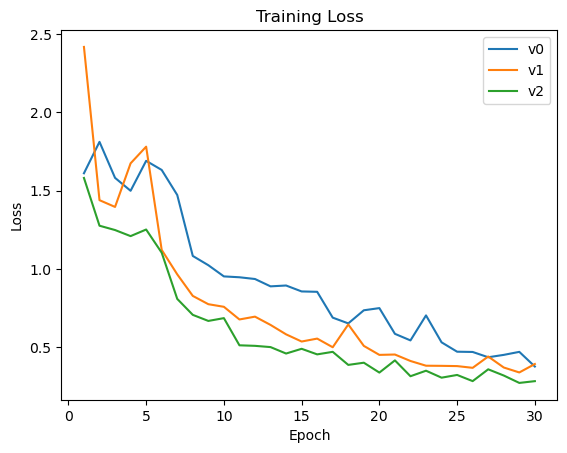

In [37]:
# # Plot
# Create corresponding x values for each array
x0 = np.arange(len(v1_30))

# Plot both arrays on the same plot
plt.plot(x0, v0_30, label='v0')
plt.plot(x0, v1_30, label='v1')
plt.plot(x0, v2_30, label='v2')
# Add title and labels
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 31, 5))

# Add a legend
plt.legend()

# Display the plot
plt.show()

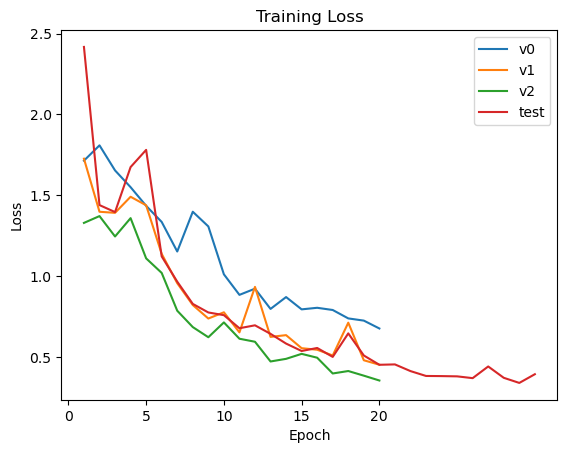

In [17]:
# # Plot
v0 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/3_PFNN/trajectory/v0_losshist.npy')
v1 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/3_PFNN/trajectory/v1_losshist.npy')
v2 = np.load('C:/Users/Ana/Desktop/dev/pfnn-dev/TrainingStats/3_PFNN/trajectory/v2_losshist.npy')

v0 = np.insert(v0, 0, np.inf)
v1 = np.insert(v1, 0, np.inf)
v2 = np.insert(v2, 0, np.inf)
loss_history = np.insert(loss_history, 0, np.inf)

# Create corresponding x values for each array
x0 = np.arange(len(v0))
x1 =np.arange(len(loss_history))

# Plot both arrays on the same plot
plt.plot(x0, v0, label='v0')
plt.plot(x0, v1, label='v1')
plt.plot(x0, v2, label='v2')
plt.plot(x1,loss_history, label='test')
# loss_history = np.insert(loss_history, 0, np.inf)

# Add title and labels
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 21, 5))

# Add a legend
plt.legend()

# Display the plot
plt.show()